# Learning objectives

In this Exercise, we will see the impact of multiple pre processing transforms.

# Installing dependencies

In [ ]:
#@formatter:off
!python -c "import monai" || pip install -qU "monai[ignite, nibabel, torchvision, tqdm]==1.2.0"
#@formatter:on

# Verify your Configuration

Execute the following cell to check MONAI's configuration using MONAI's `print_config()`.

In [ ]:
from monai.config import print_config

print_config()

# Download dataset

In this exercise, we will be using the Medical Decathlon Spleen data.

In [1]:
import os
from monai.apps import download_and_extract

directory = "./Data/msd_spleen"
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(directory, "Task09_Spleen.tar")
data_dir = os.path.join(directory, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, directory, md5)

Task09_Spleen.tar: 1.50GB [01:57, 13.7MB/s]                               

2023-11-01 17:05:48,790 - INFO - Downloaded: Data\msd_spleen\Task09_Spleen.tar


2023-11-01 17:05:51,168 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2023-11-01 17:05:51,169 - INFO - Writing into directory: ./Data/msd_spleen.


# Set MSD Spleen dataset path

The following groups images and labels from `Task09_Spleen/imagesTr` and `Task09_Spleen/labelsTr` into pairs.

In [7]:
from pathlib import Path

train_images = sorted(Path(data_dir, "imagesTr").glob("spleen*.nii.gz"))
train_labels = sorted(Path(data_dir, "labelsTr").glob("spleen*.nii.gz"))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_data_dicts, val_data_dicts = data_dicts[:-9], data_dicts[-9:]

# Verifying the input images files

In [25]:
import numpy as np
from monai.transforms import LoadImaged, Compose, EnsureChannelFirstd

trans = Compose([LoadImaged(keys=["image", "label"], image_only=False), EnsureChannelFirstd(keys=["image", "label"])])
data = trans(train_data_dicts[0])
print(f"image shape: {data['image'].shape}")
print(f"image affine:\n{data['image'].meta['affine']}")
print(f"image pixdim:\n{data['image'].pixdim}")

image shape: torch.Size([1, 512, 512, 55])
image affine:
tensor([[   0.9766,    0.0000,    0.0000, -499.0232],
        [   0.0000,    0.9766,    0.0000, -499.0232],
        [   0.0000,    0.0000,    5.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
image pixdim:
tensor([0.9766, 0.9766, 5.0000], dtype=torch.float64)


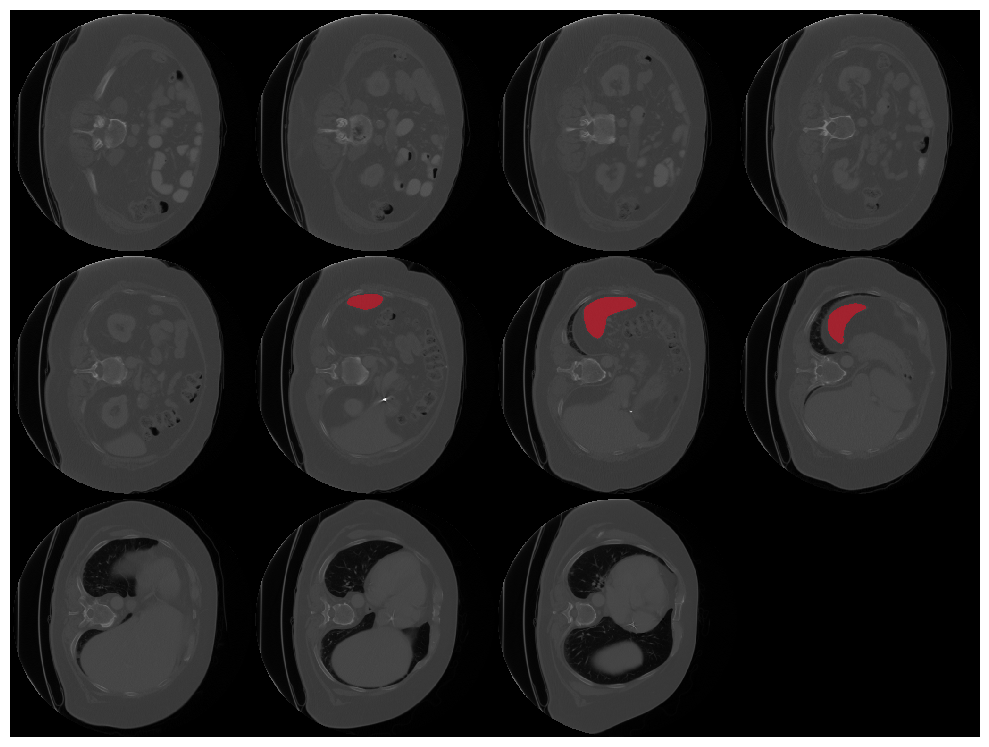

In [41]:
%matplotlib inline
from monai.visualize import matshow3d, blend_images

ret = blend_images(image=data["image"], label=data["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Ensure the first dimension is channel

1. Load the first image with a simple LoadImage
2. Apply the EnsureChannelFirstd transform
3. Compare the shape before / after transform

In [47]:
from monai.transforms import LoadImaged, EnsureChannelFirstd

loader = LoadImaged(keys=["image", "label"])
data = loader(train_data_dicts[0])

print("Loaded data shape :", data["image"].shape)

ensure_channel_first = EnsureChannelFirstd(keys=["image", "label"])
data = ensure_channel_first(data)
print("Modified data dict :", data["image"].shape)

Loaded data shape : torch.Size([512, 512, 55])
Modified data dict : torch.Size([1, 512, 512, 55])


Now we are ready to do some intensity and spatial transforms.

# Reorientation to a designated axes codes

The default axis labels are Left (L), Right (R), Posterior (P), Anterior (A), Inferior (I), Superior (S). 

1. Use `Orientationd` to change the direction of the data to the `PLI` ax codes
2. Print image shape and affine before / after the change
3. Print the original affine of the image stored in the meta data after the transform
4. Display image and label after orientation change

In [54]:
from monai.transforms import Orientationd

data = trans(train_data_dicts[0])
print(f"Image shape before:\n{data['image'].shape}")
print(f"Image affine before:\n{data['image'].meta['affine']}")

orientation = Orientationd(keys=["image", "label"], axcodes="PLI")
data = orientation(data)

print(f"Image shape after:\n{data['image'].shape}")
print(f"Image affine after:\n{data['image'].meta['affine']}")
print(f"Image original affine after:\n{data['image'].meta['original_affine']}")

Image shape before:
torch.Size([1, 512, 512, 55])
Image affine before:
tensor([[   0.9766,    0.0000,    0.0000, -499.0232],
        [   0.0000,    0.9766,    0.0000, -499.0232],
        [   0.0000,    0.0000,    5.0000,    0.0000],
        [   0.0000,    0.0000,    0.0000,    1.0000]], dtype=torch.float64)
Image shape after:
torch.Size([1, 512, 512, 55])
Image affine after:
tensor([[ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.7684e-07],
        [-9.7656e-01,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
Image original affine after:
[[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]


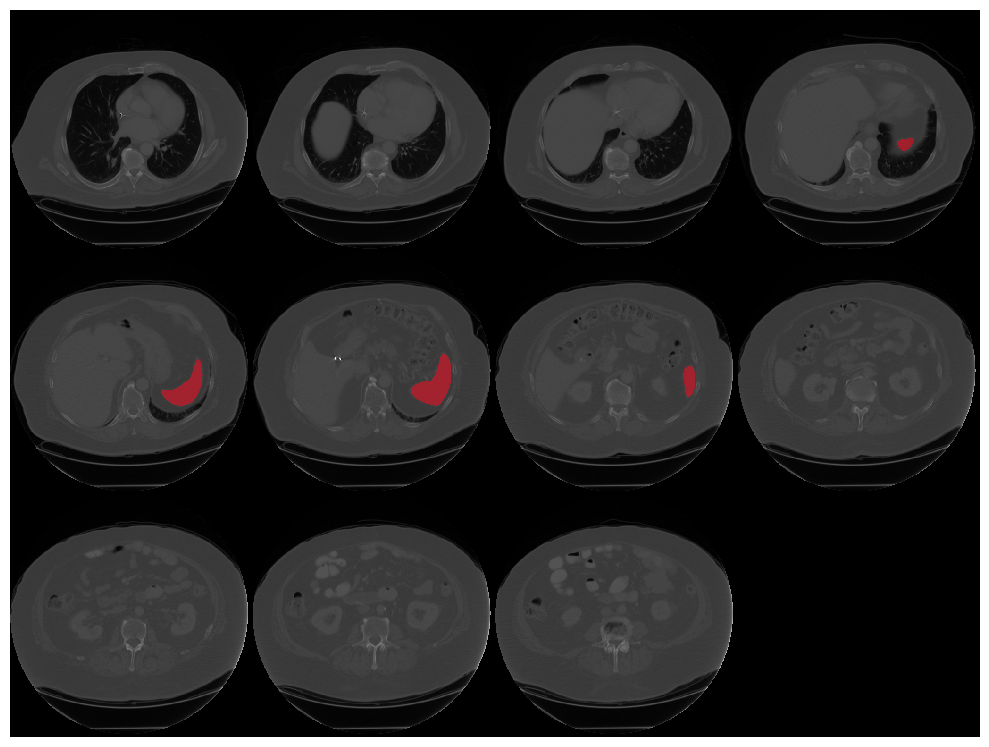

In [51]:
ret = blend_images(image=data["image"], label=data["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Resample to a consistent voxel size

1. Use MONAI's `Spacingd` transform to resample the input image and label to isotropic 1.5 size using bilinear and nearest interpolations
2. Print image shape and affine before / after the change
3. Print the original affine of the image stored in the meta data after the transform
4. Display image and label after resampling change

In [55]:
from monai.transforms import Spacingd

print(f"Image shape before:\n{data['image'].shape}")
print(f"Image affine before:\n{data['image'].meta['affine']}")

spacing = Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 1.5), mode=("bilinear", "nearest"))
data = spacing(data)

print(f"Image shape after:\n{data['image'].shape}")
print(f"Image affine after:\n{data['image'].meta['affine']}")
print(f"Image original affine after:\n{data['image'].meta['original_affine']}")

Image shape before:
torch.Size([1, 512, 512, 55])
Image affine before:
tensor([[ 0.0000e+00, -9.7656e-01,  0.0000e+00,  4.7684e-07],
        [-9.7656e-01,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -5.0000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
Image shape after:
torch.Size([1, 334, 334, 181])
Image affine after:
tensor([[ 0.0000e+00, -1.5000e+00,  0.0000e+00,  4.7684e-07],
        [-1.5000e+00,  0.0000e+00,  0.0000e+00,  4.7684e-07],
        [ 0.0000e+00,  0.0000e+00, -1.5000e+00,  2.7000e+02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64)
Image original affine after:
[[   0.97656202    0.            0.         -499.02319336]
 [   0.            0.97656202    0.         -499.02319336]
 [   0.            0.            5.            0.        ]
 [   0.            0.            0.            1.        ]]


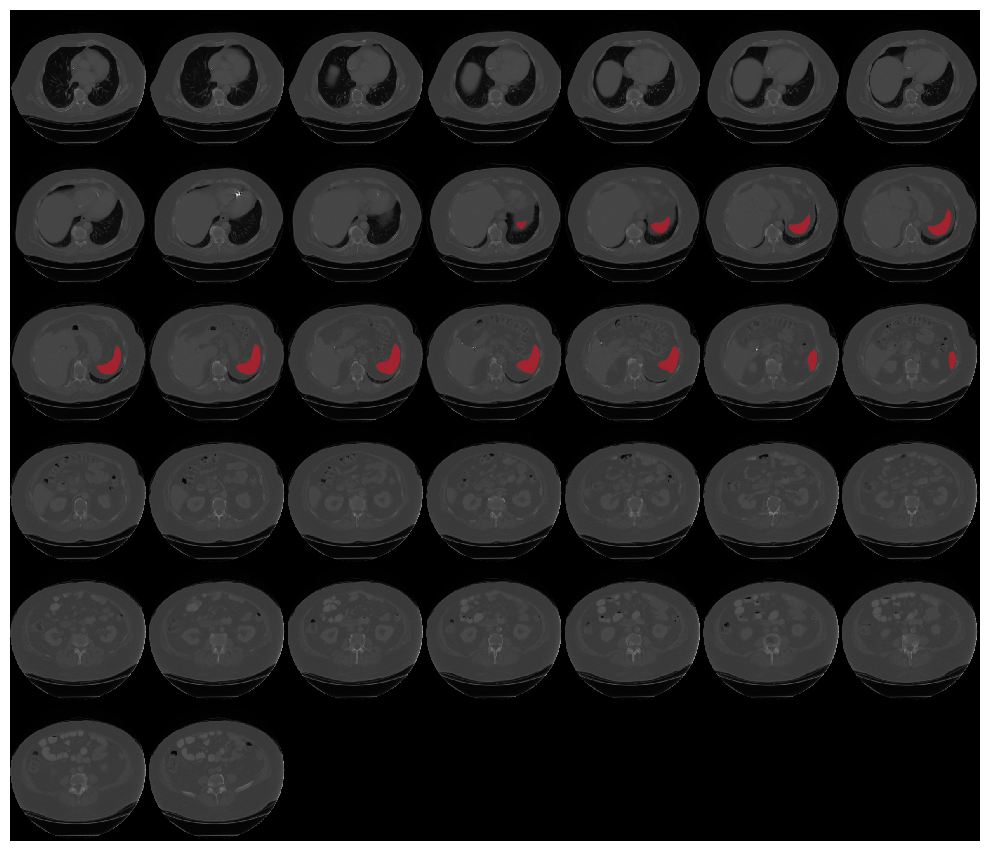

In [56]:
ret = blend_images(image=data["image"], label=data["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Random affine transformation

1. Instantiate a `RandAffined` with the following properties
    - Output spatial size : (300, 300, 100) 
    - Output translation range :  x: (-40, 40), y: (-40, 40), z: (-2, 2)
    - Output rotation range : x: (-5, 5) deg, y: (-5, 5) deg, z: (-45, 45) deg
    - Output scaling range : 1 +- 0.15 for x,y and z
    - padding_mode : "border"
    - prob : 1
2. Apply the affine transform to both image
3. Print image shape
4. Display image and label after affine transform 

In [57]:
from monai.transforms import RandAffined

rand_affine = RandAffined(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    spatial_size=(300, 300, 100),
    translate_range=(40, 40, 2),
    rotate_range=(np.deg2rad(5), np.deg2rad(5), np.deg2rad(45)),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)
rand_affine.set_random_state(seed=123)

image shape: torch.Size([1, 300, 300, 100])


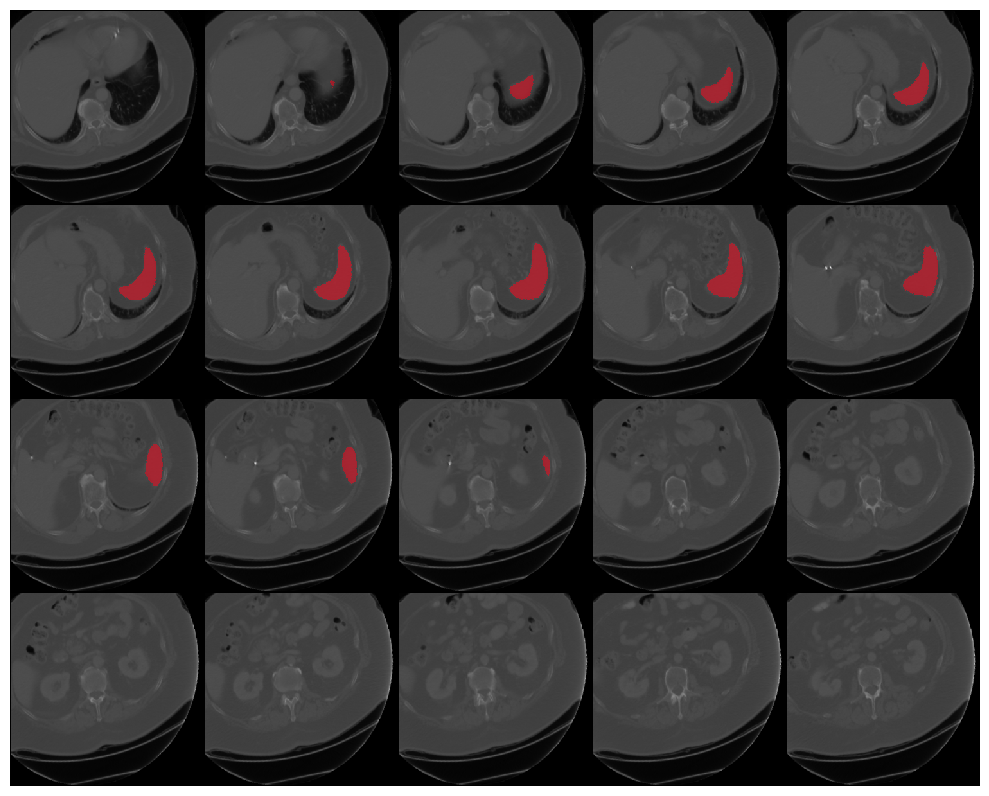

In [60]:
rand_affine_data = rand_affine(data)
print(f"image shape: {rand_affine_data['image'].shape}")

ret = blend_images(image=rand_affine_data["image"], label=rand_affine_data["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Random elastic deformation


1. Instantiate a `Rand3DElasticd` with the following properties
    - Output spatial size : (300, 300, 100) 
    - Output translation range :  x: (-50, 50), y: (-50, 50), z: (-2, 2)
    - Output rotation range : x: (-5, 5) deg, y: (-5, 5) deg, z: (-45, 45) deg
    - Output scaling range : 1 +- 0.15 for x,y and z
    - Sigma range (smoothness of deformation) : (5, 8)
    - Magnitude range (amplitude of deformation) : (100, 200)
    - padding_mode : "border"
    - prob : 1
2. Apply the affine transform to both image
3. Print image shape
4. Display image and label after transform 

In [61]:
from monai.transforms import Rand3DElasticd

rand_elastic = Rand3DElasticd(
    keys=["image", "label"],
    mode=("bilinear", "nearest"),
    prob=1.0,
    sigma_range=(5, 8),
    magnitude_range=(100, 200),
    spatial_size=(300, 300, 100),
    translate_range=(50, 50, 2),
    rotate_range=(np.deg2rad(5), np.deg2rad(5), np.deg2rad(45)),
    scale_range=(0.15, 0.15, 0.15),
    padding_mode="border",
)
rand_elastic.set_random_state(seed=123)

image shape: torch.Size([1, 300, 300, 100])


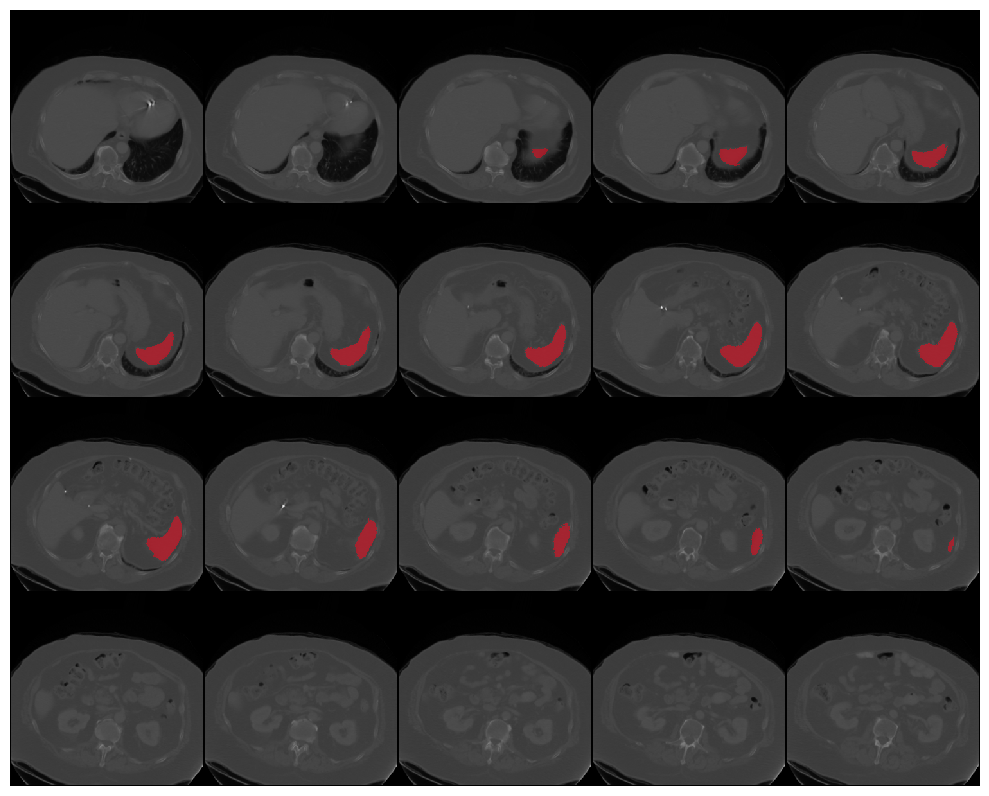

In [63]:
deformed_data_dict = rand_elastic(data)
print(f"image shape: {deformed_data_dict['image'].shape}")

ret = blend_images(image=deformed_data_dict["image"], label=deformed_data_dict["label"], alpha=0.5)
fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)

# Random crop by pos label

1. Instantiate the `RandCropByPosNegLabeld` transform with the following properties 
    - Spatial size : (96, 96, 96)
    - Number of samples 2
2. Apply the transform to the input data
3. Print the type of output data
4. Print the shape of the first sample
5. Display both samples' images and labels


In [71]:
from monai.transforms import RandCropByPosNegLabeld

rand_crop = RandCropByPosNegLabeld(
    keys=["image", "label"],
    label_key="label",
    spatial_size=(96, 96, 96),
    num_samples=2
)
rand_elastic.set_random_state(seed=123)


image shape: torch.Size([1, 96, 96, 96])


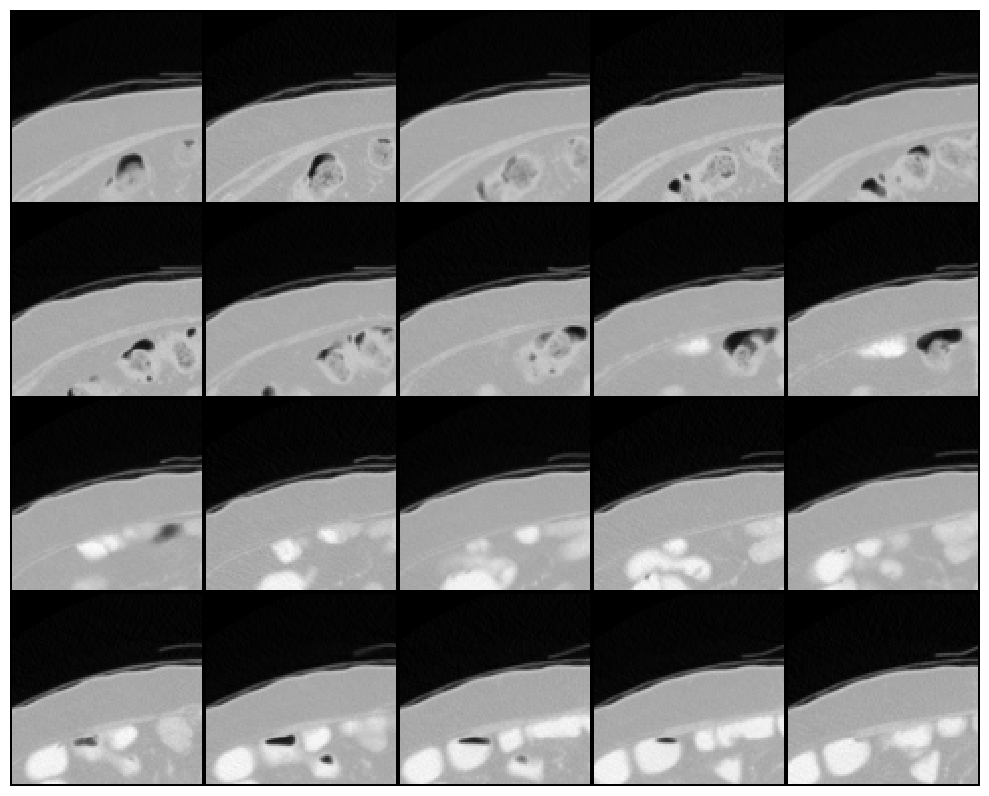

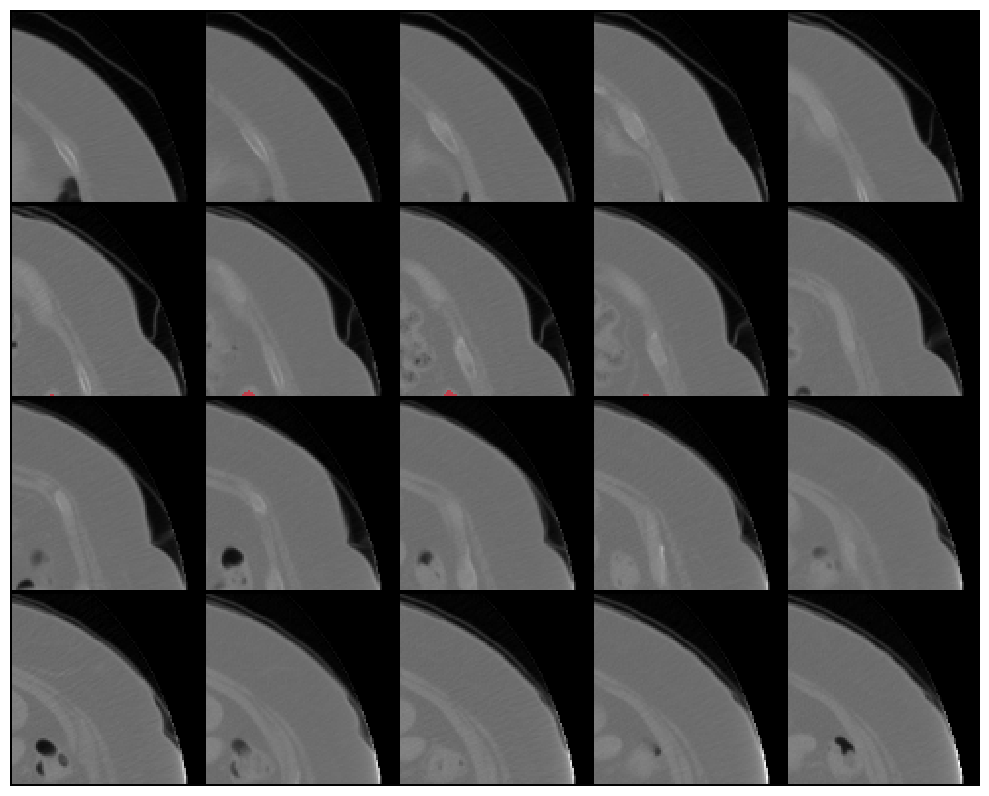

In [74]:
rand_crop_dict = rand_crop(data)
print(f"image shape: {rand_crop_dict[0]['image'].shape}")

for i_sample in range(2):
    ret = blend_images(image=rand_crop_dict[i_sample]["image"], label=rand_crop_dict[i_sample]["label"], alpha=0.5)
    fig_im = matshow3d(ret, channel_dim=0, every_n=5, frame_dim=-1)